/opt/anaconda3/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [07:55:18] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        18
           1       1.00      1.00      1.00        30
           2       1.00      1.00      1.00        24
           3       1.00      1.00      1.00        25
           4       1.00      1.00      1.00        24
           5       1.00      1.00      1.00        23
           6       1.00      1.00      1.00        33
           7       1.00      1.00      1.00        23
           8       1.00      1.00      1.00        21
           9       1.00      1.00      1.00        15
          10       1.00      1.00      1.00        23
          11       1.00      1.00      1.00        26
          12       1.00      1.00      1.00        21
          13       1.00      1.00      1.00        29
          14       1.00      1.00      1.00        24
          15       1.00      1.00      1.00        19
          16       1.00      1.00      1.00        28
    

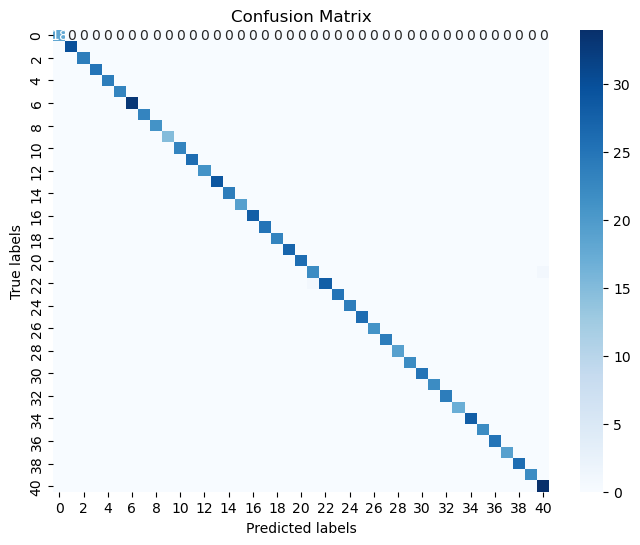

In [40]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier
from sklearn.base import BaseEstimator, ClassifierMixin
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix
import os
df = pd.read_csv('DiseaseAndSymptoms.csv')

symptom_cols = ['Symptom_1','Symptom_2','Symptom_3','Symptom_4','Symptom_5','Symptom_6']

all_symptoms_set = set()
for col in symptom_cols:
    df[col] = df[col].astype(str).fillna('missing_symptom')
    all_symptoms_set.update(df[col].unique())

if 'nan' in all_symptoms_set:
    all_symptoms_set.remove('nan')
if 'None' in all_symptoms_set:
    all_symptoms_set.remove('None')

all_symptoms = sorted(list(all_symptoms_set))

# multi hot encoding - creates a vec of 1's and 0's
def row_to_vector(row):
    row_symptoms = set(s for s in row if s != 'missing_symptom')
    return [1 if symptom in row_symptoms else 0 for symptom in all_symptoms]

vectors = df[symptom_cols].apply(row_to_vector, axis=1)

X = pd.DataFrame(vectors.tolist(), columns=all_symptoms)

# encode the diseases
label_encoder_y = LabelEncoder()
y = label_encoder_y.fit_transform(df['Disease'])


X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)


class SklearnXGBClassifier(BaseEstimator, ClassifierMixin):
    def __init__(self, **kwargs):
        self.model = XGBClassifier(**kwargs)

    def fit(self, X, y, **kwargs):
        self.model.fit(X, y, **kwargs)
        return self

    def predict(self, X):
        return self.model.predict(X)

    def predict_proba(self, X):
        return self.model.predict_proba(X)

    def get_params(self, deep=True):
        return self.model.get_params(deep)

    def set_params(self, **params):
        self.model.set_params(**params)
        return self

model = SklearnXGBClassifier(
    objective='multi:softmax',
    num_class=42,
    use_label_encoder=False,
    eval_metric='logloss'
)

model.fit(X_train, y_train)

# Predict on the test set
y_pred = model.predict(X_test)

print("Classification Report:")
print(classification_report(y_test, y_pred))

conf_matrix = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:")
print(conf_matrix)

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()


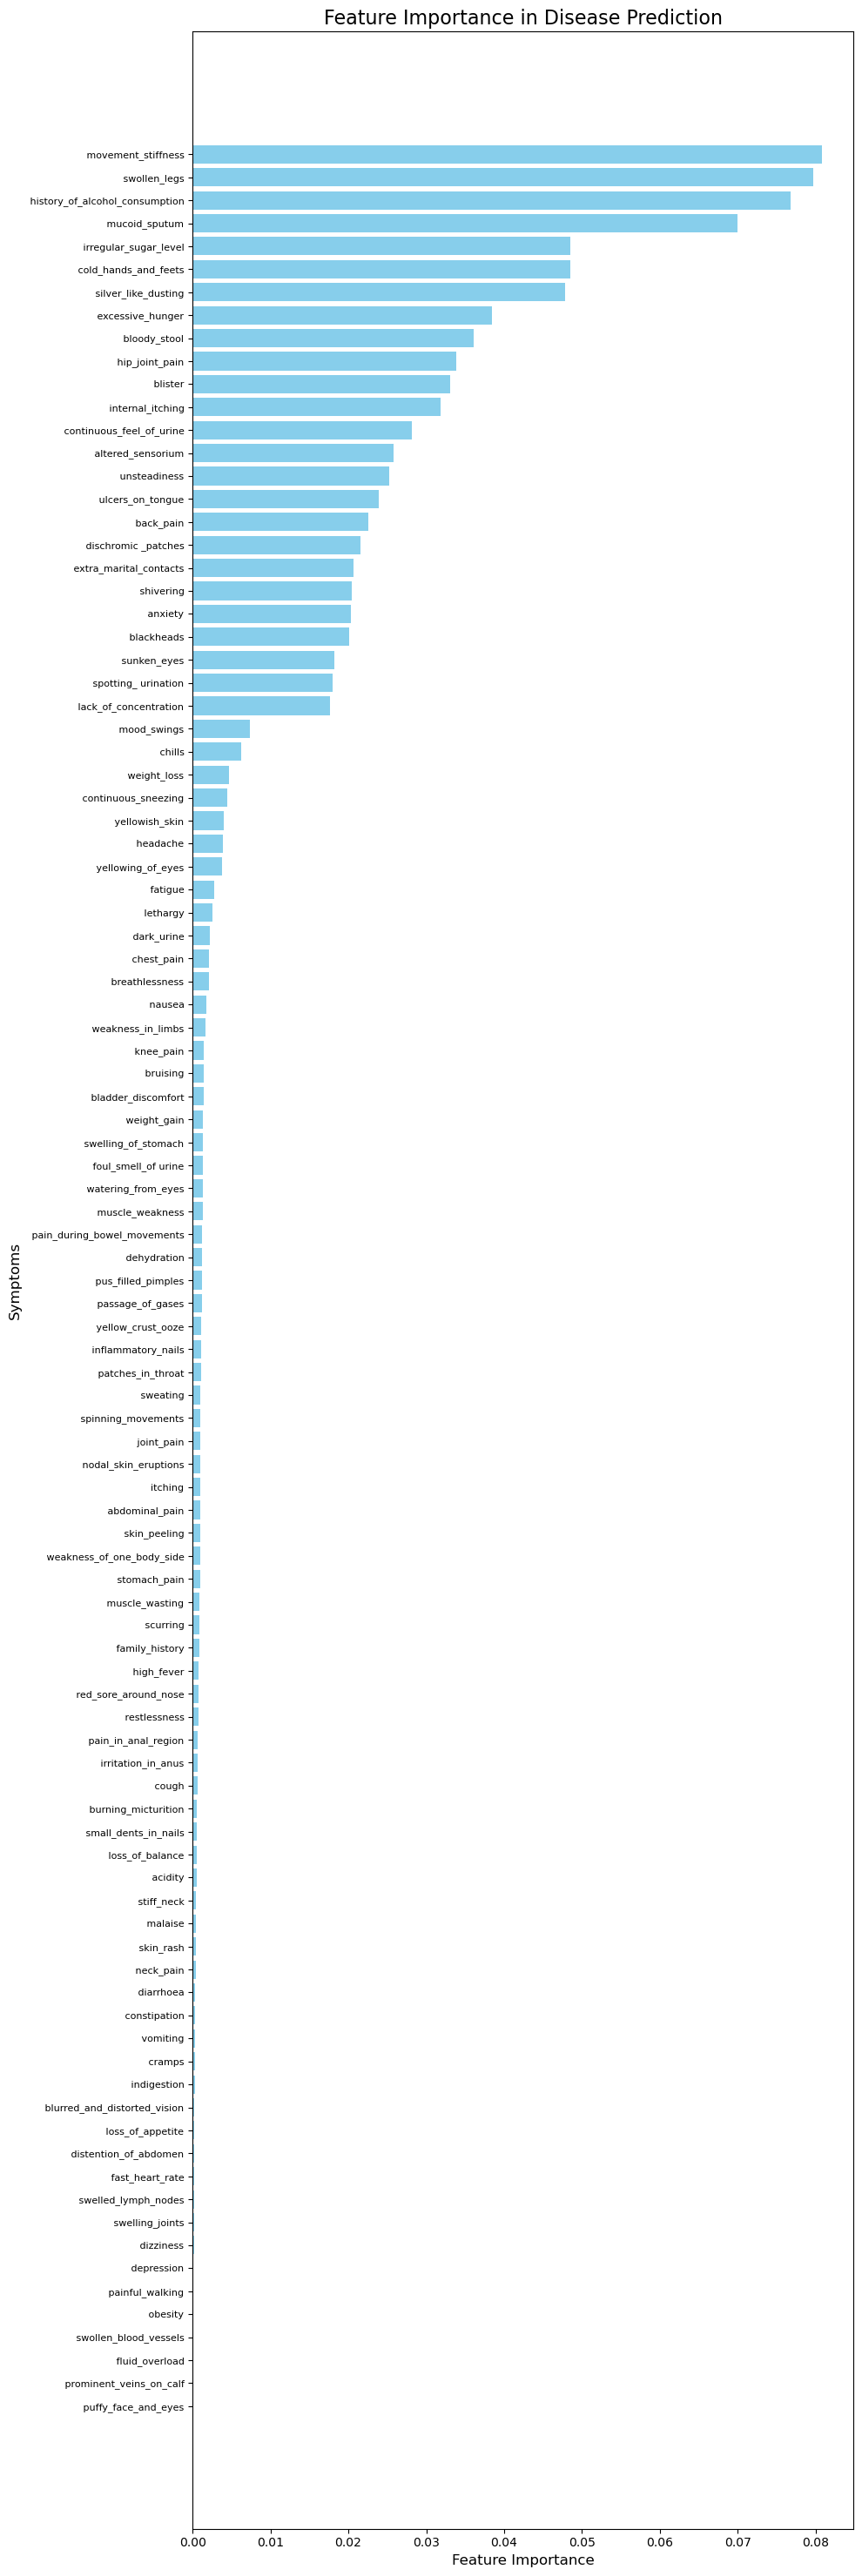

In [36]:
feature_importances = model.model.feature_importances_
features = X.columns
sorted_idx = feature_importances.argsort()[::-1]
sorted_features = features[sorted_idx]
sorted_importances = feature_importances[sorted_idx]

plt.figure(figsize=(10, len(features) * 0.3))
plt.barh(sorted_features, sorted_importances, color='skyblue')
plt.xlabel('Feature Importance', fontsize=12)
plt.ylabel('Symptoms', fontsize=12)
plt.title('Feature Importance in Disease Prediction', fontsize=16)
plt.gca().invert_yaxis() 
plt.xticks(fontsize=10)
plt.yticks(fontsize=8)
plt.tight_layout()
plt.show()


In [44]:
import json
file_path = "output_file.json"
with open(file_path, 'r') as file:
    data = json.load(file)
print(data)

    
test_symptoms = [item['symptom'] for item in data]

test_vec = [1 if symptom in test_symptoms else 0 for symptom in all_symptoms]

test_vec_df = pd.DataFrame([test_vec], columns=all_symptoms)

probs = model.predict_proba(test_vec_df)

sorted_indices = np.argsort(probs[0])[::-1]

top_n = 5
top_n_indices = sorted_indices[:top_n]

print("Top", top_n, "most likely diseases:")
for i, disease_idx in enumerate(top_n_indices, start=1):
    disease_name = label_encoder_y.inverse_transform([disease_idx])[0]
    probability = probs[0][disease_idx]
    print(f"{i}. {disease_name} - Probability: {probability:.4f}")

[{'symptom': 'itching'}, {'symptom': ' internal_itching'}, {'symptom': ' indigestion'}, {'symptom': ' stomach_pain'}, {'symptom': ' abdominal_pain'}, {'symptom': ' belly_pain'}, {'symptom': ' swelling_of_stomach'}, {'symptom': ' diarrhoea'}, {'symptom': ' vomiting'}, {'symptom': ' nausea'}]
Top 5 most likely diseases:
1. Peptic ulcer diseae - Probability: 0.5051
2. Chronic cholestasis - Probability: 0.4680
3. Alcoholic hepatitis - Probability: 0.0129
4. Drug Reaction - Probability: 0.0022
5. Gastroenteritis - Probability: 0.0019
